In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from package.RankAMIP.logistic import run_logistic_regression
from package.RankAMIP.data_script import make_BT_design_matrix
from package.RankAMIP.logistic import LogisticAMIP
from package.RankAMIP.logistic import find_closest_matchups
from package.RankAMIP.logistic import isRankingRobust

### Is ChatBot Arena Data Robust?

### Data Pre-processing

In [2]:
# Import datasets from https://huggingface.co/datasets/lmarena-ai/arena-human-preference-55k
from datasets import load_dataset
ds = load_dataset("lmarena-ai/arena-human-preference-55k")

In [3]:
# inspect the available splits
print(ds)  
# grab the ‘train’ split (or whatever splits ds has)
train = ds["train"]
# look at the first example
print(train[0])

DatasetDict({
    train: Dataset({
        features: ['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b', 'winner_model_a', 'winner_model_b', 'winner_tie'],
        num_rows: 57477
    })
})
{'id': 30192, 'model_a': 'gpt-4-1106-preview', 'model_b': 'gpt-4-0613', 'prompt': '["Is it morally right to try to have a certain percentage of females on managerial positions?","OK, does pineapple belong on a pizza? Relax and give me fun answer."]', 'response_a': '["The question of whether it is morally right to aim for a certain percentage of females in managerial positions is a complex ethical issue that involves considerations of fairness, equality, diversity, and discrimination.\\n\\nHere are some arguments in favor of and against such policies:\\n\\n**Arguments in favor:**\\n\\n1. **Correcting Historical Inequities:** Women have historically been underrepresented in leadership roles due to various cultural, institutional, and social barriers. Aiming for a specific percentage can

In [255]:
df = train.to_pandas()
df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


In [ ]:
# how to get the unique names in both columns
model_a_names = df['model_a'].unique()
model_b_names = df['model_b'].unique()
# combine the two arrays and get the unique names
model_names = np.unique(np.concatenate((model_a_names, model_b_names)))
# print the number of unique model names
print(f"Number of unique model names: {len(model_names)}")

Number of unique model names: 64


In [256]:
ties = df[df['winner_tie'] == 1]
print(f"Number of ties: {len(ties)}")
# proportion of ties.
print(f"Proportion of ties: {len(ties) / len(df):.2%}")

Number of ties: 17761
Proportion of ties: 30.90%


There are 17761 ties in the data set.

In [206]:
def break_ties_randomly(df, seed=6):
    np.random.seed(seed)
    tie_indices = df[df['winner_tie'] == 1].index
    # Random choices: 1 means assign to model_a, 0 to model_b
    assign_to_a = np.random.choice([0, 1], size=len(tie_indices))
    
    for idx, assign in zip(tie_indices, assign_to_a):
        if assign == 1:
            df.at[idx, 'winner_model_a'] = 1
            df.at[idx, 'winner_model_b'] = 0
        else:
            df.at[idx, 'winner_model_a'] = 0
            df.at[idx, 'winner_model_b'] = 1
    
    return df

In [207]:
df_no_ties = break_ties_randomly(df,seed=2)
# df_no_ties.head(20)
df_no_ties.shape
# select the model_a, model_b, and winner columns
rawBT = df_no_ties[['model_a', 'model_b', 'winner_model_a']]
rawBT.head()
# make a design matrix.
X, y, player_to_id = make_BT_design_matrix(rawBT)
###


In [208]:
# make a design matrix.
X, y, player_to_id = make_BT_design_matrix(rawBT)
X.shape, y.shape

((57477, 63), (57477,))

In [123]:
ks = [1]
alphaNs = [10]

results = {}
for k in ks:
    for alphaN in alphaNs:
        chatbotA, chatbotB, chatbotOriginalBetaDiff, chatNewBetaDiff, chatIndices = isRankingRobust(k, alphaN, X, y)
        results[(k, alphaN)] = (chatbotA, chatbotB, chatbotOriginalBetaDiff, chatNewBetaDiff, chatIndices)

testing new matchup:  21 None


In [252]:
import importlib
import package.RankAMIP.plot_util
from package.RankAMIP.plot_util import *
# Make changes to your_local_module.py file
# Then reload it
importlib.reload(package.RankAMIP.plot_util)

<module 'package.RankAMIP.plot_util' from '/Users/JennyH/Desktop/IsRankingRobust/package/RankAMIP/plot_util.py'>

In [253]:
from package.RankAMIP.plot_util import *
rankings = return_rankings_list(X, y, results, 1, 10, player_to_id)

In [254]:
filename_to_save = 'fig/test_highquality.png'
plot_bt_scores(X, y, rankings, alphaN, 10, filename_to_save)

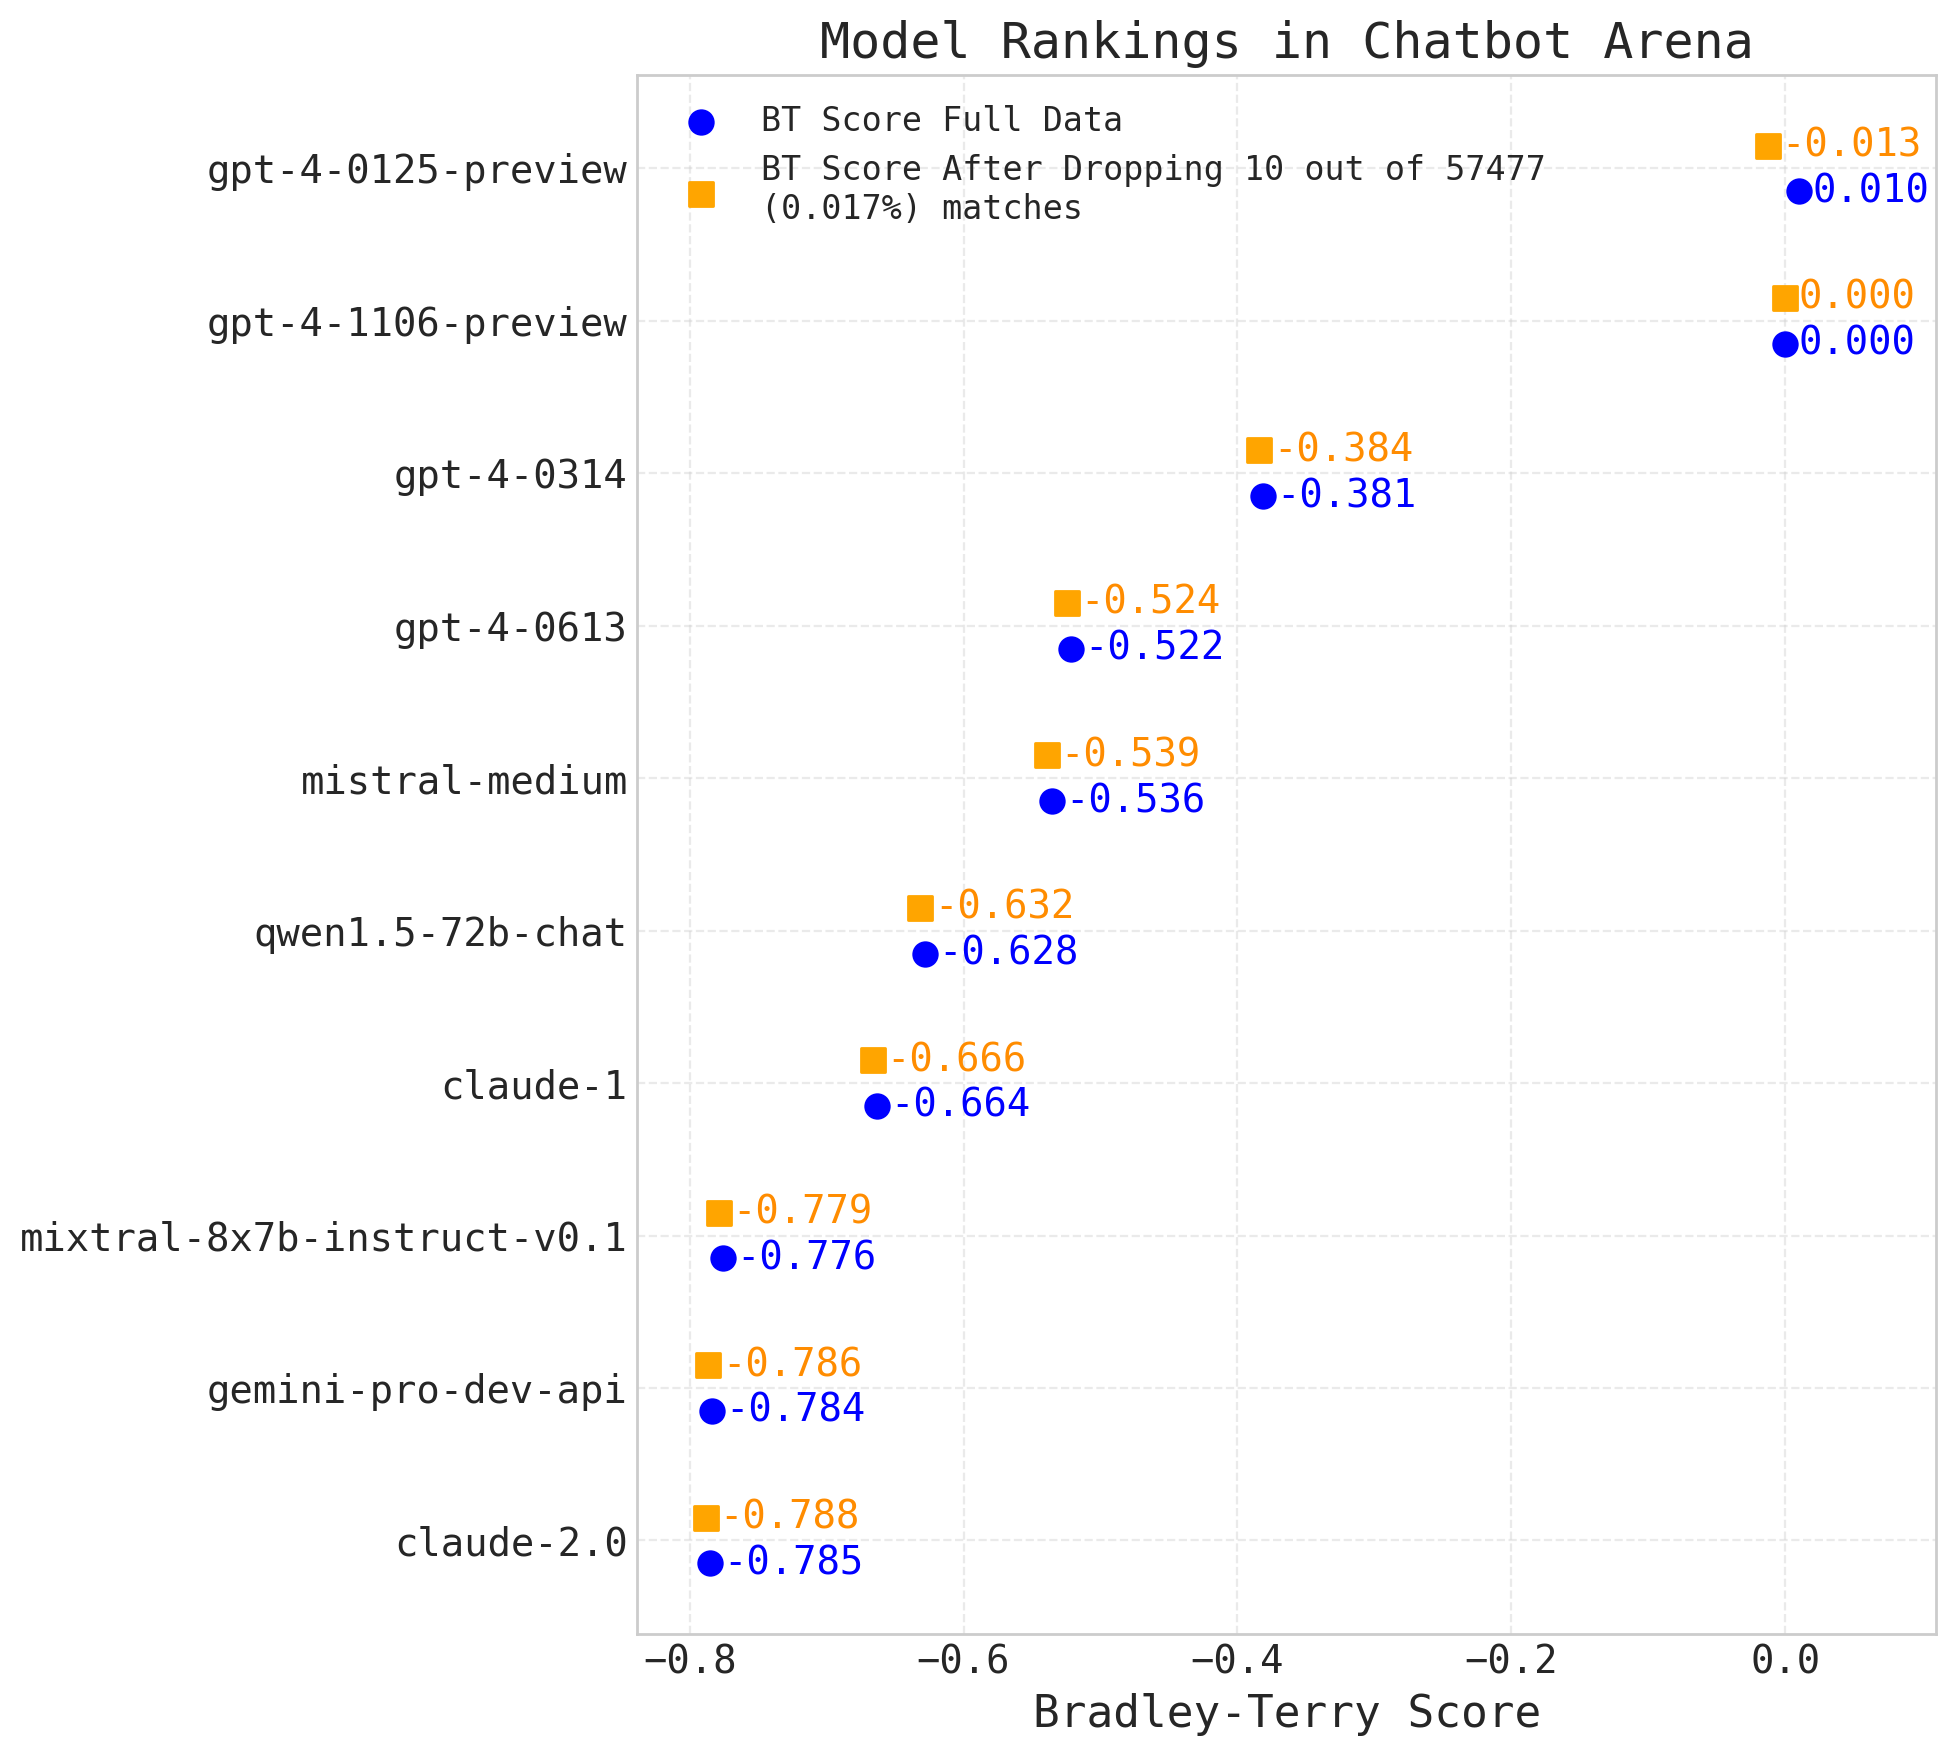

In [247]:
topk = 10
# Extract top-k entries
# Sorted by old_scores (index 2) in descending.
rankings = sorted(rankings[:topk], key=lambda x: x[2], reverse=False)
model_names = [x[0] for x in rankings[:topk]]
old_scores = [x[2] for x in rankings[:topk]]
new_scores = [x[3] for x in rankings[:topk]]
num_matches_total = len(y)
y_plot = np.arange(len(rankings[:topk]))
offset = 0.15

# Plot
import matplotlib.pyplot as plt

# Set global font to monospace and increase default font size
plt.rcParams.update({
    'font.family': 'monospace',
    'font.size': 14
})

# Plot
plt.figure(figsize=(10, 9), dpi=200)

# Scatter points
plt.scatter(old_scores, y_plot - offset, label='BT Score Full Data', marker='o', color='blue', s=72)
plt.scatter(new_scores, y_plot + offset, 
            label=f'BT Score After Dropping {alphaN} out of {num_matches_total}\n'
                  f'({(alphaN/num_matches_total * 100):.3f}%) matches',
            marker='s', color='orange', s=72)

# Extend x-axis limits slightly to the left and right
min_score = min(min(old_scores), min(new_scores))
max_score = max(max(old_scores), max(new_scores))
plt.xlim(min_score - 0.05, max_score + 0.1)

# Annotate scores next to points
for i in range(len(y_plot)):
    plt.text(old_scores[i] + 0.01, y_plot[i] - offset, f'{old_scores[i]:.3f}', 
             va='center', ha='left', fontsize=14, fontfamily='monospace', color='blue')
    plt.text(new_scores[i] + 0.01, y_plot[i] + offset, f'{new_scores[i]:.3f}', 
             va='center', ha='left', fontsize=14, fontfamily='monospace', color='darkorange')

# Axis formatting
plt.xlabel('Bradley-Terry Score', fontsize=16, fontfamily='monospace')
plt.yticks(y_plot, model_names, fontsize=14, fontfamily='monospace')
plt.xticks(fontsize=14, fontfamily='monospace')
plt.title('Model Rankings in Chatbot Arena', fontsize=18, fontfamily='monospace')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


We find that the score for gpt-4-0125-preview flips with that of gpt-4-1106-preview with only 10 out of 50k matches dropped. These were the original first and second-ranking models, by quite a landslide.

In [ ]:
playerA, playerB, indices = results[(1, 10)]

### Inspect the dropped human evals.

In [138]:
# check the human evals that were dropped to change the top model.
# dropped comparisons: 
# get the rows in df that have these indices.
mis_df = df.iloc[indices][['model_a', 'model_b', 'winner_model_a', 'winner_tie']]
mis_df
# save the df to a csv file.
# mistral_df.to_csv('fig/mistral_df.csv', index=False)


,model_a,model_b,winner_model_a,winner_tie
45535,gpt-4-0125-preview,gpt-4-1106-preview,1,0
13696,gpt-4-0125-preview,gpt-4-1106-preview,1,0
4566,gpt-4-0125-preview,gpt-4-1106-preview,1,1
12544,gpt-4-0125-preview,gpt-4-1106-preview,1,0
35786,gpt-4-0125-preview,gpt-4-1106-preview,1,1
7657,gpt-4-0125-preview,gpt-4-1106-preview,1,0
44022,gpt-4-0125-preview,gpt-4-1106-preview,1,1
12586,gpt-4-0125-preview,gpt-4-1106-preview,1,1
57338,gpt-4-0125-preview,gpt-4-1106-preview,1,0
7386,gpt-4-0125-preview,gpt-4-1106-preview,1,1


In [238]:
# MIS: prompts.
for prompt in df.iloc[indices[:5]]['prompt'].tolist():
    print(prompt)


["Why am I so happy after drinking alcohol? It's like I have forgotten all my problems, and I don't feel anything but happy and calm."]
["what is 1 plus 1"]
["how many lights do I have in my home"]
["Continue this list with plausible social groups, ideology and accusation:\n\nSocial group\tTheory\/ideology\tAccusation\nJews\tZionism\tAntisemitism\nWomen\tFeminism\tSexism\/misogyny\nTrans\tGender identity ideology\tTransphobia\nBlack\tCritical race theory\tRacism\nChinese\tChinese Communist Party\tAnti-Chinese\nVeterans\tJustice of war\tDisrespect of veterans\nSports fans\tValue of sports\tAnti-Australians\nMen\tMale violence\tMisandry\nMuslims\tIslam\tIslamophobia\nMuslims\tHalal\tIslamophobia\nSex workers\tSex market as good\tAnti-sex worker\nAcademics\tLimit population growth\tRacist\/eugenicist\/colonial\nAmericans\tUS foreign policy\tAnti-American\nCatalans\tSeparatism\tCatalanophobia\nLesbians\tSeparatism \tMan-hating\nGay men\tMisogyny\tHomophobia\nWomen\tFemininity \tWoman-hatin

In [239]:
# MIS: response A.
for responseA in df.iloc[indices[:5]]['response_a'].tolist():
    print(responseA)

["Alcohol can make you feel happy and relaxed because it can affect the levels of certain neurotransmitters in your brain, such as dopamine and serotonin. These chemicals are naturally produced in your brain and can contribute to feelings of pleasure and well-being. When you consume alcohol, it can increase the levels of these neurotransmitters, leading to feelings of happiness and relaxation.\n\nHowever, it is important to note that alcohol can also have negative effects on your mental and physical health, and it is not a healthy or sustainable way to cope with problems or stress. If you are relying on alcohol to feel happy or calm, it may be helpful to speak with a mental health professional about healthier ways to manage your emotions and cope with stress."]
["The sum of 1 plus 1 is 2. In mathematical terms, if you have one object or value, and you add another one, the total number of objects or values you have is the sum of the two, which is 2 in this case."]
["I'm just an AI, I do

In [240]:
# MIS: response B.
for responseB in df.iloc[indices[:5]]['response_b'].tolist():
    print(responseB)

["Alcohol is a central nervous system depressant that can have various effects on mood and emotions. When you consume alcohol, it can cause the release of certain chemicals in the brain, such as endorphins and dopamine, which are associated with feelings of happiness and pleasure. Alcohol can also help to decrease anxiety and inhibitions, making you feel more relaxed and calm. However, it's important to note that these effects are temporary, and the negative consequences of alcohol consumption, such as hangovers and long-term health problems, can outweigh the initial pleasurable feelings. Additionally, relying on alcohol as a way to cope with problems or negative emotions can lead to dependence and addiction. If you are concerned about your alcohol consumption or are experiencing negative consequences, it may be helpful to speak with a healthcare professional or substance abuse counselor."]
["The answer to 1 plus 1 is 2."]
["I'm unable to provide an exact answer to that question as I d

### Simulated Toy Game (for demo purposes).

In [16]:
# Set seed for reproducibility
np.random.seed(42)

# --- Step 1: Define teams and latent strengths ---
teams = ['A', 'B', 'C', 'D', 'E', 'F']
team_ids = {name: i for i, name in enumerate(teams)}
true_betas = np.array([0.05, 0.04, 0.03, -0.00, -0.01, -0.02])  # (note: we should try out different signal levels later).
num_teams = len(teams)

n_games = 10000
matchups = []

for _ in range(n_games):
    i, j = np.random.choice(6, size=2, replace=False) # randomly choose 2 teams to compete.
    beta_diff = true_betas[i] - true_betas[j]
    prob_win_i = 1 / (1 + np.exp(-beta_diff))
    winner = i if np.random.rand() < prob_win_i else j
    matchups.append((i, j, winner))


X = np.zeros((n_games, 5))  # We fix beta_0 = 0 and estimate beta_1 and beta_2.
y = np.zeros(n_games)

for idx, (i, j, winner) in enumerate(matchups):
    # Map to reduced index space (beta_0 = 0)
    def reduced(k): return k - 1 if k > 0 else None
    
    if winner == i:
        y[idx] = 1
        if reduced(i) is not None:
            X[idx, reduced(i)] += 1
        if reduced(j) is not None:
            X[idx, reduced(j)] -= 1
    else:
        y[idx] = 0
        if reduced(j) is not None:
            X[idx, reduced(j)] += 1
        if reduced(i) is not None:
            X[idx, reduced(i)] -= 1

In [18]:
X.shape

(10000, 5)

In [11]:
myAMIP = LogisticAMIP(X, y, fit_intercept=False, penalty=None)
# inputs: alphaN, player1, player2.
# returns: sign_change_amip, sign_change_refit, original_beta_diff, new_beta_diff_amip, new_beta_diff_refit, indices of top alphaN matches.
results = myAMIP.AMIP_sign_change(40, 0, 1)
print(results)

(True, True, 0.03796672855776561, -0.001111486029315406, -0.0018768168345150854, array([4999,  925, 8624, 8603, 4852, 4853, 8595,  924, 4865, 3313, 4881,
       3309, 4890,  996, 8523, 4875, 8642, 4829, 4800, 4659,  791, 8800,
       8797, 4689, 8783, 4706, 3390, 3386, 4756, 8700, 4770,  871,  884,
       4786, 8495, 8838, 8471, 4957, 8065, 5248]))
